# Setup


## Instalando biblioteca


In [3]:
%pip install -U scikit-fuzzy
%pip install pyswarm


Note: you may need to restart the kernel to use updated packages.


## Utilitários


In [4]:
import skfuzzy as fuzz
import pandas as pd

class ResultadoSimulacao:
    def __init__(self, rotulo, valor, pertinencias):
        self.rotulo = rotulo
        self.valor = valor
        self.pertinencias = pertinencias

    def ver(self):
        print(f"Nivel de risco: {self.valor:.2f}\n")

        for label, p in self.pertinencias.items():
            print(f"Pertinância de '{label}': {p:.2f}")

        print(f"Risco {self.rotulo}")
    

def interpretar_resultado(valor_risco, universo, mostrar=True):
    pertinencias = {}
    
    for label in universo.terms:
        pertinencias[label] = fuzz.interp_membership(universo.universe, universo[label].mf, valor_risco)

    mais_pertinente, _ = max(pertinencias.items(), key=lambda x: x[1])       

    return ResultadoSimulacao(mais_pertinente, valor_risco, pertinencias)

2025-02-13 20:34:04,678 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


# Exemplo da biblioteca


/Users/lpds/anaconda3/lib/python3.11/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


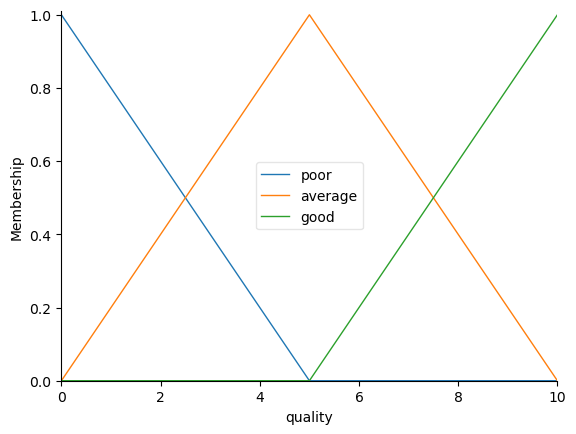

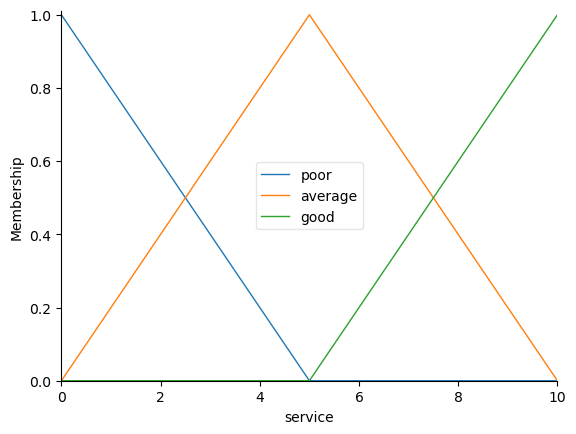

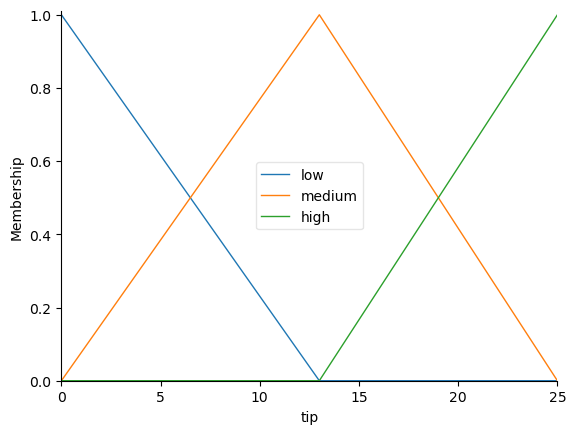

In [5]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
quality = ctrl.Antecedent(np.arange(0, 11, 1), "quality")
service = ctrl.Antecedent(np.arange(0, 11, 1), "service")
tip = ctrl.Consequent(np.arange(0, 26, 1), "tip")

# Auto-membership function population is possible with .automf(3, 5, or 7)
quality.automf(3)
service.automf(3)

# # Custom membership functions can be built interactively with a familiar,
# # Pythonic API
tip["low"] = fuzz.trimf(tip.universe, [0, 0, 13])
tip["medium"] = fuzz.trimf(tip.universe, [0, 13, 25])
tip["high"] = fuzz.trimf(tip.universe, [13, 25, 25])

quality.view()
service.view()
tip.view()

In [6]:
rule1 = ctrl.Rule(quality["poor"] | service["poor"], tip["low"])
rule2 = ctrl.Rule(service["average"], tip["medium"])
rule3 = ctrl.Rule(service["good"] | quality["good"], tip["high"])

In [7]:
tipping_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
tipping = ctrl.ControlSystemSimulation(tipping_ctrl)

# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
tipping.input["quality"] = "poor"
tipping.input["service"] = "good"

tip.defuzzify_method = "bisector"

# Crunch the numbers
tipping.compute()

print(f"Defuzzified value: {tipping.output['tip']}\n")
for label in tip.terms:
    membership_value = fuzz.interp_membership(tip.universe, tip[label].mf, tipping.output["tip"])
    print(f"Membership of '{label}': {membership_value}")

Defuzzified value: 10.450490243203605

Membership of 'low': 0.19611613513818424
Membership of 'medium': 0.8038838648618158
Membership of 'high': 0.0


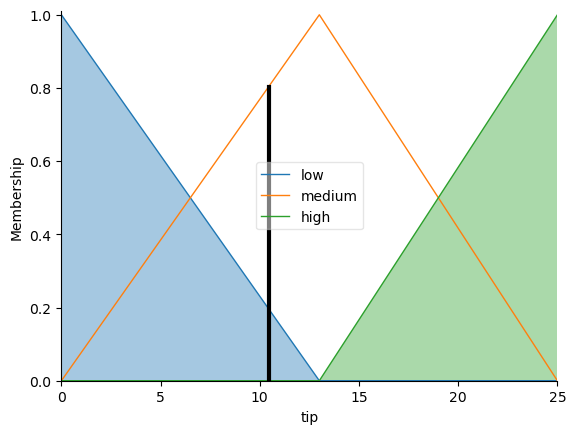

In [8]:
tip.view(sim=tipping)

# Exercício: Matriz de Risco


## Inferência com regras

### 1: Modelo básico

In [9]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd

# Criar as variáveis fuzzy
severity = ctrl.Antecedent(np.arange(0, 6, 1), 'severity')
probability = ctrl.Antecedent(np.arange(0, 6, 1), 'probability')
risk = ctrl.Consequent(np.arange(0, 2, 1), 'risk')

# Definir funções de pertinência para severidade
severity['negligenciavel'] = fuzz.trimf(severity.universe, [0, 1, 2])
severity['baixo'] = fuzz.trimf(severity.universe, [1, 2, 3])
severity['moderado'] = fuzz.trimf(severity.universe, [2, 3, 4])
severity['significativo'] = fuzz.trimf(severity.universe, [3, 4, 5])
severity['catastrofico'] = fuzz.trimf(severity.universe, [4, 5, 5])

# Definir funções de pertinência para probabilidade
probability['improvavel'] = fuzz.trimf(probability.universe, [0, 1, 2])
probability['remoto'] = fuzz.trimf(probability.universe, [1, 2, 3])
probability['ocasional'] = fuzz.trimf(probability.universe, [2, 3, 4])
probability['provavel'] = fuzz.trimf(probability.universe, [3, 4, 5])
probability['frequente'] = fuzz.trimf(probability.universe, [4, 5, 5])

# Definir funções de pertinência para risco (apenas aceitável ou inaceitável)
risk['aceitavel'] = fuzz.trimf(risk.universe, [0, 0, 0.5])
risk['inaceitavel'] = fuzz.trimf(risk.universe, [0.5, 1, 1])

# Definir regras baseadas na matriz de risco
rules = [
    # Regras para risco inaceitável (células laranjas)
    ctrl.Rule(severity['catastrofico'] & probability['remoto'], risk['inaceitavel']),
    ctrl.Rule(severity['catastrofico'] & probability['ocasional'], risk['inaceitavel']),
    ctrl.Rule(severity['catastrofico'] & probability['provavel'], risk['inaceitavel']),
    ctrl.Rule(severity['catastrofico'] & probability['frequente'], risk['inaceitavel']),
    
    ctrl.Rule(severity['significativo'] & probability['remoto'], risk['inaceitavel']),
    ctrl.Rule(severity['significativo'] & probability['ocasional'], risk['inaceitavel']),
    ctrl.Rule(severity['significativo'] & probability['provavel'], risk['inaceitavel']),
    ctrl.Rule(severity['significativo'] & probability['frequente'], risk['inaceitavel']),
    
    ctrl.Rule(severity['moderado'] & probability['ocasional'], risk['inaceitavel']),
    ctrl.Rule(severity['moderado'] & probability['provavel'], risk['inaceitavel']),
    ctrl.Rule(severity['moderado'] & probability['frequente'], risk['inaceitavel']),
    
    # Regras para risco aceitável (células brancas)
    ctrl.Rule(severity['negligenciavel'] & probability['improvavel'], risk['aceitavel']),
    ctrl.Rule(severity['negligenciavel'] & probability['remoto'], risk['aceitavel']),
    ctrl.Rule(severity['negligenciavel'] & probability['ocasional'], risk['aceitavel']),
    ctrl.Rule(severity['negligenciavel'] & probability['provavel'], risk['aceitavel']),
    ctrl.Rule(severity['negligenciavel'] & probability['frequente'], risk['aceitavel']),
    
    ctrl.Rule(severity['baixo'] & probability['improvavel'], risk['aceitavel']),
    ctrl.Rule(severity['baixo'] & probability['remoto'], risk['aceitavel']),
    ctrl.Rule(severity['baixo'] & probability['ocasional'], risk['aceitavel']),
    ctrl.Rule(severity['baixo'] & probability['provavel'], risk['aceitavel']),
    ctrl.Rule(severity['baixo'] & probability['frequente'], risk['aceitavel']),
    
    ctrl.Rule(severity['moderado'] & probability['improvavel'], risk['aceitavel']),
    ctrl.Rule(severity['moderado'] & probability['remoto'], risk['aceitavel']),
    
    ctrl.Rule(severity['significativo'] & probability['improvavel'], risk['aceitavel']),
    
    ctrl.Rule(severity['catastrofico'] & probability['improvavel'], risk['aceitavel'])
]

# Criar e simular o sistema de controle fuzzy
risco_controle = ctrl.ControlSystem(rules)
risco_simulacao = ctrl.ControlSystemSimulation(risco_controle)

def calculate_risk(sev_value, prob_value):
    """
    Calcula o risco baseado nos valores de severidade e probabilidade
    
    Args:
        sev_value (float): Valor da severidade (1-5)
        prob_value (float): Valor da probabilidade (1-5)
    
    Returns:
        str: 'Aceitável' ou 'Inaceitável'
    """
    risco_simulacao.input['severity'] = sev_value
    risco_simulacao.input['probability'] = prob_value
    
    try:
        risco_simulacao.compute()
        risk_value = risco_simulacao.output['risk']
        return "Inaceitável" if risk_value >= 0.5 else "Aceitável"
    except:
        return "Erro"

def generate_risk_matrix():
    """
    Gera uma matriz de risco no formato de DataFrame do pandas
    com todas as combinações possíveis de severidade e probabilidade
    
    Returns:
        pandas.DataFrame: Matriz de risco com os resultados
    """
    # Definir rótulos para linhas e colunas
    severity_labels = ['Catastrófico', 'Significativo', 'Moderado', 'Baixo', 'Negligenciável']
    probability_labels = ['Improvável', 'Remoto', 'Ocasional', 'Provável', 'Frequente']
    
    # Criar matriz vazia
    matrix = []
    
    # Calcular risco para cada combinação
    for sev_idx, sev_label in enumerate(severity_labels, 1):
        row = []
        for prob_idx, prob_label in enumerate(probability_labels, 1):
            # Converter índices para valores de 1-5 (reverso para severidade)
            sev_value = 6 - sev_idx  # Para manter a ordem correta (5,4,3,2,1)
            prob_value = prob_idx    # 1,2,3,4,5
            
            result = calculate_risk(sev_value, prob_value)
            row.append(result)
        matrix.append(row)
    
    # Criar DataFrame
    df = pd.DataFrame(matrix, 
                     index=severity_labels,
                     columns=probability_labels)
    
    return df

print("Matriz de Risco")
generate_risk_matrix()

Matriz de Risco


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Significativo,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Moderado,Aceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Baixo,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Negligenciável,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável


### 2: Modelo com input de tolerância

In [10]:
import numpy as np
from skfuzzy import control as ctrl
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# Criar as variáveis fuzzy
severidade = ctrl.Antecedent(np.arange(0, 6, 1), "severidade")
probabilidade = ctrl.Antecedent(np.arange(0, 6, 1), "probabilidade")
tolerancia = ctrl.Antecedent(np.arange(0, 3, 1), "tolerancia")
risco = ctrl.Consequent(np.arange(0, 2, 1), "risco")

severidade.automf(names=["negligenciavel", "baixo", "moderado", "significativo", "catastrofico"])
probabilidade.automf(names=["improvavel", "remoto", "ocasional", "provavel", "frequente"])
tolerancia.automf(names=["alta", "moderada", "baixa"])
risco.automf(names=["aceitavel", "inaceitavel"])

regras = [
    # Tolerância moderada
    ctrl.Rule(tolerancia["moderada"] & probabilidade["improvavel"], risco["aceitavel"]),
    ctrl.Rule(tolerancia["moderada"] & (severidade["baixo"] | severidade["negligenciavel"]), risco["aceitavel"]),
    ctrl.Rule(tolerancia["moderada"] & (severidade["moderado"] & probabilidade["remoto"]), risco["aceitavel"]),
    # Tolerância alta
    ctrl.Rule(tolerancia["alta"] & probabilidade["improvavel"], risco["aceitavel"]),
    ctrl.Rule(
        tolerancia["alta"] & (severidade["baixo"] | severidade["negligenciavel"] | severidade["moderado"]),
        risco["aceitavel"],
    ),
    ctrl.Rule(tolerancia["alta"] & (severidade["significativo"] & probabilidade["remoto"]), risco["aceitavel"]),
    # Tolerância baixa
    ctrl.Rule(tolerancia["baixa"] & (severidade["negligenciavel"]), risco["aceitavel"]),
    ctrl.Rule(tolerancia["baixa"] & (severidade["baixo"] & probabilidade["remoto"]), risco["aceitavel"]),
    ctrl.Rule(tolerancia["baixa"] & (severidade["catastrofico"] & probabilidade["improvavel"]), risco["inaceitavel"]),
    ctrl.Rule(tolerancia["baixa"] & (severidade["significativo"] & probabilidade["improvavel"]), risco["aceitavel"]),
]

# Criar e simular o sistema de controle fuzzy
risco_controle = ctrl.ControlSystem(regras)
risco_simulacao = ctrl.ControlSystemSimulation(risco_controle)


def calcular_risco(severidade, probabilidade, tolerancia):
    risco_simulacao.input["severidade"] = severidade
    risco_simulacao.input["probabilidade"] = probabilidade
    risco_simulacao.input["tolerancia"] = tolerancia

    try:
        risco_simulacao.compute()
        valor = risco_simulacao.output["risco"]
        return "Inaceitável" if valor > 0.5 else "Aceitável"
    except KeyError:
        return "Inaceitável"
    except:
        return "Erro"
    finally:
        risco_simulacao.reset()



def gerar_matriz_de_risco(tolerancia):
    # Definir rótulos para linhas e colunas
    rotulos_severidade = ["Catastrófico", "Significativo", "Moderado", "Baixo", "Negligenciável"]
    rotulos_probabilidade = ["Improvável", "Remoto", "Ocasional", "Provável", "Frequente"]

    # Criar matriz vazia
    matrix = []

    # Calcular risco para cada combinação
    for sev_idx, _ in enumerate(rotulos_severidade, 1):
        row = []
        for prob_idx, _ in enumerate(rotulos_probabilidade, 1):
            # Converter índices para valores de 1-5 (reverso para severidade)
            sev_valor = 6 - sev_idx  # Para manter a ordem correta (5,4,3,2,1)
            prob_valor = prob_idx  # 1,2,3,4,5

            result = calcular_risco(sev_valor, prob_valor, tolerancia)
            row.append(result)
        matrix.append(row)

    # Criar DataFrame
    df = pd.DataFrame(matrix, index=rotulos_severidade, columns=rotulos_probabilidade)

    return df.style.map(lambda val: "background-color: blue" if val == "Aceitável" else "background-color: orange")


for tol in ["Alta", "Moderada", "Baixa"]:
    print(f"Matriz de Risco - Tolerancia {tol}")
    display(gerar_matriz_de_risco(tol.lower()))

Matriz de Risco - Tolerancia Alta


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Significativo,Aceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Moderado,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Baixo,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Negligenciável,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável


Matriz de Risco - Tolerancia Moderada


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Significativo,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Moderado,Aceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Baixo,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Negligenciável,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável


Matriz de Risco - Tolerancia Baixa


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Inaceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Significativo,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Moderado,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Baixo,Aceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Negligenciável,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável


## Inferência sem regras
### Modelo com input de tolerância e sem regras

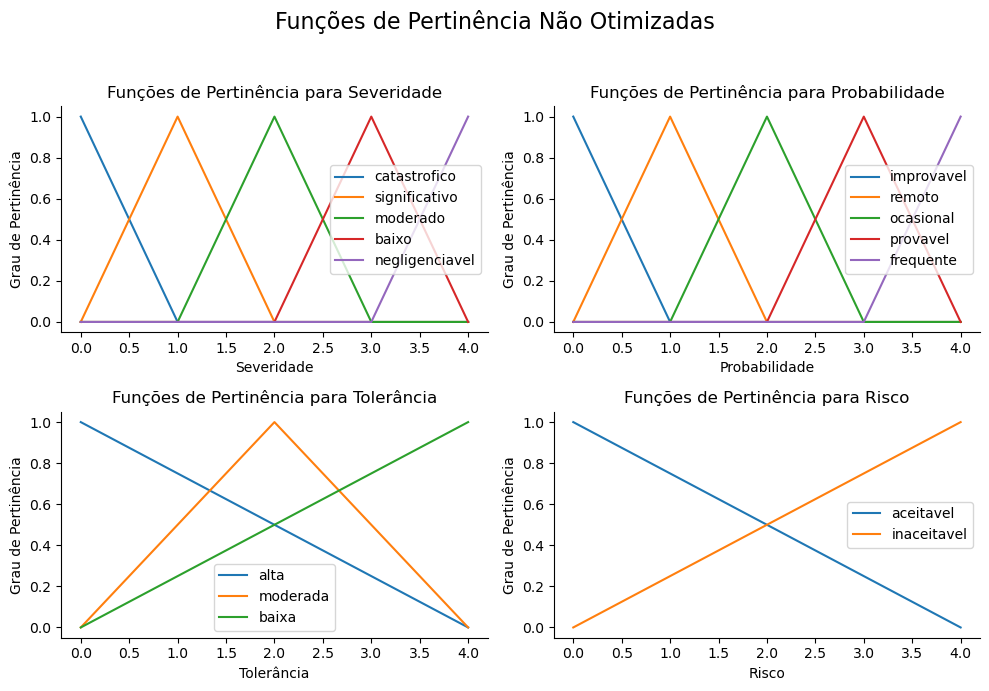

In [11]:
import matplotlib.pyplot as plt

SEVERIDADE = "severidade"
PROBABIBILIDADE = "probabilidade"
TOLERANCIA = "tolerancia"
RISCO = "risco"

CODIGOS_SEVERIDADE = ["catastrofico", "significativo", "moderado", "baixo", "negligenciavel"]
CODIGOS_PROBABILIDADE = ["improvavel", "remoto", "ocasional", "provavel", "frequente"]
CODIGOS_TOLERANCIA = ["alta", "moderada", "baixa"]
CODIGOS_RISCO = ["aceitavel", "inaceitavel"]

ROTULOS_TOLERANCIA = ["Alta", "Moderada", "Baixa"]
ROTULOS_SEVERIDADE = ["Catastrófico", "Significativo", "Moderado", "Baixo", "Negligenciável"]
ROTULOS_PROBABILIDADE = ["Improvável", "Remoto", "Ocasional", "Provável", "Frequente"]
ROTULOS_RISCO = ["Aceitável", "Inaceitável"]


# Gerando universos
x_sev = np.arange(0, 5, 1)
x_prob = np.arange(0, 5, 1)
x_tol = np.arange(0, 5, 1)
x_risc = np.arange(0, 5, 1)

# Gerando funções de pertinência
# ABC para cada função de pertinencia
sev_abc = [
    [0, 0, 1],  # negligenciavel
    [0, 1, 2],  # baixo
    [1, 2, 3],  # moderado
    [2, 3, 4],  # significativo
    [3, 4, 4],  # catastrofico
]

prob_abc = [
    [0, 0, 1],  # improvavel
    [0, 1, 2],  # remoto
    [1, 2, 3],  # ocasional
    [2, 3, 4],  # provavel
    [3, 4, 4],  # frequente
]

tol_abc = [
    [0, 0, 4],  # alta
    [0, 2, 4],  # moderada
    [0, 4, 4],  # baixa
]

risc_abc = [
    [0, 0, 4],  # aceitavel
    [0, 4, 4],  # inaceitavel
]

# Funções de pertinência
fp_sev = {label: fuzz.trimf(x_sev, lista) for label, lista in zip(CODIGOS_SEVERIDADE, sev_abc)}
fp_prob = {label: fuzz.trimf(x_prob, lista) for label, lista in zip(CODIGOS_PROBABILIDADE, prob_abc)}
fp_tol = {label: fuzz.trimf(x_tol, lista) for label, lista in zip(CODIGOS_TOLERANCIA, tol_abc)}
fp_risc = {label: fuzz.trimf(x_risc, lista) for label, lista in zip(CODIGOS_RISCO, risc_abc)}

# Lista de universos e funções de pertinência
universes = [
    (x_sev, fp_sev, "Severidade", SEVERIDADE),
    (x_prob, fp_prob, "Probabilidade", PROBABIBILIDADE),
    (x_tol, fp_tol, "Tolerância", TOLERANCIA),
    (x_risc, fp_risc, "Risco", RISCO),
]

# Criando subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

# Plotando as funções de pertinência
for i, (x, fp, title, codigo) in enumerate(universes):
    ax = axs[i // 2, i % 2]
    for label, mf in fp.items():
        ax.plot(x, mf, label=label)
    ax.set_title(f"Funções de Pertinência para {title}")
    ax.set_xlabel(title)
    ax.set_ylabel("Grau de Pertinência")
    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

fig.suptitle("Funções de Pertinência Não Otimizadas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
from skfuzzy.defuzzify import defuzz


def calcular_risco_sem_regras(severidade, probabilidade, tolerancia, plotar=False):
    uniao = fuzz.fuzzy_or(x_sev, fp_sev[severidade], x_prob, fp_prob[probabilidade])
    uniao = fuzz.fuzzy_or(*uniao, x_tol, fp_tol[tolerancia])
    
    try:
        centroide = defuzz(*uniao, "centroid")
    except fuzz.EmptyMembershipError:
        centroide = 2

    p_aceitavel = fuzz.interp_membership(x_risc, fp_risc["aceitavel"], centroide)
    p_inaceitavel = fuzz.interp_membership(x_risc, fp_risc["inaceitavel"], centroide)
    resultado = "Aceitável" if p_aceitavel >= p_inaceitavel else "Inaceitável"

    if plotar:
        print(severidade, probabilidade, f"{resultado} - {centroide:.2f}")
        plt.plot(*uniao)
        plt.title(f"Centroide: {centroide:.2f} - Risco: {resultado}")
        plt.plot(centroide, 0, "ro")
        plt.show()

    return resultado


def gerar_matriz_de_risco_sem_regras(tolerancia):
    # Criar matriz vazia
    matrix = []

    # Calcular risco para cada combinação
    for sev in CODIGOS_SEVERIDADE:
        row = []
        for prob in CODIGOS_PROBABILIDADE:
            result = calcular_risco_sem_regras(sev, prob, tolerancia)
            row.append(result)
        matrix.append(row)

    # Criar DataFrame
    df = pd.DataFrame(matrix, index=ROTULOS_SEVERIDADE, columns=ROTULOS_PROBABILIDADE)

    return df.style.map(lambda val: "background-color: blue" if val == "Aceitável" else "background-color: orange")


for tol in ROTULOS_TOLERANCIA:
    print(f"Matriz de Risco - Tolerancia {tol}")
    display(gerar_matriz_de_risco_sem_regras(tol.lower()))

Matriz de Risco - Tolerancia Alta


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Significativo,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Moderado,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Baixo,Aceitável,Aceitável,Aceitável,Aceitável,Inaceitável
Negligenciável,Aceitável,Aceitável,Aceitável,Inaceitável,Aceitável


Matriz de Risco - Tolerancia Moderada


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Aceitável,Aceitável,Aceitável,Aceitável,Aceitável
Significativo,Aceitável,Aceitável,Aceitável,Aceitável,Inaceitável
Moderado,Aceitável,Aceitável,Aceitável,Inaceitável,Inaceitável
Baixo,Aceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Negligenciável,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável


Matriz de Risco - Tolerancia Baixa


,Improvável,Remoto,Ocasional,Provável,Frequente
Catastrófico,Inaceitável,Aceitável,Inaceitável,Inaceitável,Inaceitável
Significativo,Aceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Moderado,Inaceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Baixo,Inaceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável
Negligenciável,Inaceitável,Inaceitável,Inaceitável,Inaceitável,Inaceitável


In [ ]:
from pyswarms.single import GlobalBestPSO, LocalBestPSO, GeneralOptimizerPSO
from pyswarms.backend.topology import Ring  # You can choose other topologies
from joblib import Parallel, delayed
import numpy as np


# Função de custo para comparar as matrizes de risco
def funcao_custo(params):
    custos = []
    for param in params:
        # Atualizar funções de pertinência com os parâmetros otimizados
        try:
            for i, label in enumerate(CODIGOS_SEVERIDADE):
                sev_param = np.sort(param[i * 3 : (i + 1) * 3])
                fp_sev[label] = fuzz.trimf(x_sev, sev_param)

            for i, label in enumerate(CODIGOS_PROBABILIDADE):
                prob_param = np.sort(param[15 + i * 3 : 18 + i * 3])
                fp_prob[label] = fuzz.trimf(x_prob, prob_param)

            for i, label in enumerate(CODIGOS_TOLERANCIA):
                tol_param = np.sort(param[30 + i * 3 : 33 + i * 3])
                fp_tol[label] = fuzz.trimf(x_tol, tol_param)

            for i, label in enumerate(CODIGOS_RISCO):
                risc_param = np.sort(param[39 + i * 3 : 42 + i * 3])
                fp_risc[label] = fuzz.trimf(x_risc, risc_param)
        except:
            custos.append(1e10)
            continue

        # Gerar matrizes de risco para diferentes tolerâncias
        diferenca_total = 0
        for tol in ["alta", "moderada", "baixa"]:
            matriz_com_regras = gerar_matriz_de_risco(tol).data
            matriz_sem_regras = gerar_matriz_de_risco_sem_regras(tol).data

            # Calcular a diferença entre as matrizes
            diferenca = np.sum(matriz_com_regras.values != matriz_sem_regras.values)
            diferenca_total += diferenca

        custos.append(diferenca_total)

    return np.array(custos)


def funcao_custo_paralela(positions, n_jobs=6):
    costs = Parallel(n_jobs=n_jobs)(delayed(funcao_custo)(positions[i : i + 1]) for i in range(len(positions)))
    return np.array(costs).flatten()


# Definir limites para os parâmetros
lb = [0, 0, 0] * 15
ub = [4, 4, 4] * 15

# Executar PSO
# # Definir posições iniciais das partículas com base nas definições iniciais dos dicts de funções de pertinência
initial_positions = np.tile(
    np.array(sum(sev_abc + prob_abc + tol_abc + risc_abc, []), dtype=np.float64), (20, 1)
).reshape(20, 45)

# # Configurar o otimizador PSO com as posições iniciais
optimizer = LocalBestPSO(
    n_particles=20,
    dimensions=45,
    options={"c1": 2, "c2": 1, "w": 0.9, "k": 2, "p": 2},
    bounds=(lb, ub),
    init_pos=initial_positions,
    velocity_clamp=(0.1, 1),
)

# # Executar o otimizador
best_cost, params_otimizados = optimizer.optimize(funcao_custo_paralela, iters=30)

2025-02-13 21:20:35,447 - pyswarms.single.local_best - INFO - Optimize for 30 iters with {'c1': 2, 'c2': 1, 'w': 0.9, 'k': 2, 'p': 1}
pyswarms.single.local_best: 100%|██████████|30/30, best_cost=22
2025-02-13 21:22:40,487 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 22.0, best pos: [1.36309554 1.67282766 2.46815748 1.73112217 2.58480099 3.69272876
 2.88941846 3.73050546 3.61946122 3.32870561 2.0872092  3.28232006
 0.44133457 3.0510781  3.66098742 1.50198712 1.7329819  2.65160841
 1.92303433 2.3621124  3.98079866 2.89870432 3.30546016 0.66662154
 3.65891429 2.26077335 3.00275818 3.74953485 3.02699216 3.77283787
 1.7949144  1.64088952 3.02638283 1.53627614 3.46172882 3.07320591
 1.96406358 3.54138316 3.24444796 1.90261278 1.8246676  3.47125567
 1.9044767  3.4388206  3.21463804]


In [ ]:
from pyswarms.utils.plotters import plot_cost_history

plot_cost_history(cost_history=optimizer.cost_history);

In [ ]:
# Definindo as funcoes de pertinencia otimizadas
for i, label in enumerate(CODIGOS_SEVERIDADE):
    fp_sev[label] = fuzz.trimf(x_sev, np.sort(params_otimizados[i * 3: (i + 1) * 3]))

for i, label in enumerate(CODIGOS_PROBABILIDADE):
    fp_prob[label] = fuzz.trimf(x_prob, np.sort(params_otimizados[15 + i * 3: 18 + i * 3]))

for i, label in enumerate(CODIGOS_TOLERANCIA):
    fp_tol[label] = fuzz.trimf(x_tol, np.sort(params_otimizados[30 + i * 3: 33 + i * 3]))

for i, label in enumerate(CODIGOS_RISCO):
    fp_risc[label] = fuzz.trimf(x_risc, np.sort(params_otimizados[39 + i * 3: 42 + i * 3]))

# Plotar as funções de pertinência otimizadas
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

for i, (x, fp, title, codigo) in enumerate(universes):
    ax = axs[i // 2, i % 2]
    for label, mf in fp.items():
        ax.plot(x, mf, label=label)
    ax.set_title(f"Funções de Pertinência Otimizadas para {title}")
    ax.set_xlabel(title)
    ax.set_ylabel("Grau de Pertinência")
    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

fig.suptitle("Funções de Pertinência Otimizadas", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
for tol in ROTULOS_TOLERANCIA:
    print(f"Matriz de Risco - Tolerancia {tol}")
    display(gerar_matriz_de_risco_sem_regras(tol.lower()))